# Компьютер говорит "Нет"

In [1680]:
import random
from statsmodels.stats.multitest import multipletests
import os.path
import pandas_profiling
from scipy import stats
import itertools as it
from collections import Counter
from datetime import datetime, timedelta
import re
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn import preprocessing
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.base import BaseEstimator
from sklearn import pipeline
from pandas import Series
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


import copy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Задача
Построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

## Данные
### Предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

| Признак | Описание |
| :--- | :--- | 
| client_id | идентификатор клиента |
| education | уровень образования |
| sex | пол заёмщика |
| age | возраст заёмщика |
| car | флаг наличия автомобиля |
| car_type | флаг автомобиля-иномарки |
| decline_app_cnt | количество отказанных прошлых заявок |
| good_work | флаг наличия «хорошей» работы |
| bki_request_cnt | количество запросов в БКИ |
| home_address | категоризатор домашнего адреса |
| work_address | категоризатор рабочего адреса |
| income | доход заёмщика |
| foreign_passport | наличие загранпаспорта |
| sna | связь заемщика с клиентами банка |
| first_time | давность наличия информации о заемщике |
| score_bki | скоринговый балл по данным из БКИ |
| region_rating | рейтинг региона |
| app_date | дата подачи заявки |
| default | наличие дефолта |

### Посмотрим на данные
<a id='load_data'></a>

In [1681]:
train = pd.read_csv('../input/sf-dst-scoring/train.csv')
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [1682]:
# Дата представлена в формате %d%b%Y - сразу переведем в тип datetime
train['app_date'] = pd.to_datetime(train['app_date'])

In [1683]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73492 non-null  object        
 3   sex               73799 non-null  object        
 4   age               73799 non-null  int64         
 5   car               73799 non-null  object        
 6   car_type          73799 non-null  object        
 7   decline_app_cnt   73799 non-null  int64         
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  int64         
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

In [1684]:
train.describe(datetime_is_numeric=True).transpose()

,count,mean,min,25%,50%,75%,max,std
client_id,73799.0,55137.965094,1.0,27440.5,55274.0,82758.5,110147.0,31841.921168
app_date,73799,2014-03-03 00:51:01.504898816,2014-01-01 00:00:00,2014-02-03 00:00:00,2014-03-04 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,NaN
age,73799.0,39.280641,21.0,30.0,37.0,48.0,72.0,11.520378
decline_app_cnt,73799.0,0.275749,0.0,0.0,0.0,0.0,33.0,0.804272
good_work,73799.0,0.164894,0.0,0.0,0.0,0.0,1.0,0.371087
score_bki,73799.0,-1.904724,-3.624586,-2.259534,-1.920823,-1.569831,0.199773,0.498231
bki_request_cnt,73799.0,2.000339,0.0,0.0,1.0,3.0,53.0,2.252073
region_rating,73799.0,56.725701,20.0,50.0,50.0,60.0,80.0,13.055717
home_address,73799.0,1.575509,1.0,1.0,2.0,2.0,3.0,0.527631
work_address,73799.0,2.49628,1.0,2.0,3.0,3.0,3.0,0.689818


In [1685]:
train.describe(exclude=[np.number, np.datetime64],
               datetime_is_numeric=True).transpose()

,count,unique,top,freq
education,73492,5,SCH,38860
sex,73799,2,F,41562
car,73799,2,N,49832
car_type,73799,2,N,59791
foreign_passport,73799,2,N,62733


##### Промежуточные выводы
Данные представлены за период с 2014-01-01 по 2014-04-30, кол-во записей - 73799, только столбец education имеет пропуски.

## EDA
<a id='eda'></a>
[Goto data load](#load_data)

### Для начала поробуем pandas_profiling

In [1686]:
# для того, чтобы предотвратить повторный вызов профайлера, проверим наличие результатов его работы
if not os.path.exists('eda_profiling.html'):
    profile = pandas_profiling.ProfileReport(
        train, title='Credit scoring profiler report', explorative=True)
    profile.to_file('eda_profiling.html')

[EDA profiling output](eda_profiling.html)

##### Промежуточные выводы
* client_id - полностью уникальный идентификатор - исключить
* education - имеет пропуски (307, <0.1%) - заменить пропуски на UNK
* age - имеется несколько экстремально старых клиентов, распределение скошено влево - изучить подробнее
* car и car_type - посмотреть есть ли записи с car=N и car_type=Y (не может быть), так же обнаружена корреляция крамера для этх признаков
* decline_app_cnt - имеются клиенты с количеством отказов больше 20 - изучить подробнее
* bki_request_cnt - имеются записи с экстремально большими значениями - изучить подробнее
* income - имеется несколько клиентов с очень большим и очень маленьким доходом, распределение сильно скошено влево - log и изучить подробнее


In [1687]:
def outliers(df, feature):
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def get_stat_dif(df, feature, target, dropna=True, check=True, alpha=0.5):
    cols = df.loc[:, feature].value_counts(dropna=dropna).index
    combinations_all = list(it.combinations(cols, 2))
    p_values = []
    p_combs = []
    bonferony = []
    for comb in combinations_all:
        len0 = len(df.loc[df.loc[:, feature] == comb[0]])
        len1 = len(df.loc[df.loc[:, feature] == comb[1]])
        if check and len(df.loc[df.loc[:, feature] == comb[0]]) < 30:
            msg = 'Количество значений {} ({}) = {} (<30) тест стьюдента может дать некорректные результаты'.format(
                feature, comb[0], len0)
#            raise Exception(msg)
            continue
        if check and len(df.loc[df.loc[:, feature] == comb[1]]) < 30:
            msg = 'Количество значений {} ({}) = {} (<30) тест стьюдента может дать некорректные результаты'.format(
                feature, comb[1], len1)
#            raise Exception(msg)
            continue
        res = stats.ttest_ind(df.loc[df.loc[:, feature] == comb[0], target],
                              df.loc[df.loc[:, feature] == comb[1], target])
        p_combs.append(comb)
        p_values.append(res.pvalue)
        # Учли поправку Бонферони
        if res.pvalue <= alpha / len(combinations_all):
            print(
                f'Найдены статистически значимые различия для {feature} (поправка Бонферони)  комбинация {comb} p-value {res.pvalue}')
            bonferony.append(comb)

    res = multipletests(p_values, alpha=alpha, method='holm-sidak')
    rejected = []
    for i in range(0, len(res[0])):
        if res[0][i] == True:  # Гипотеза отвергается
            #            print(f'Найдены статистически значимые различия для {feature} (поправка Холм-Сидака)  комбинация {p_combs[i]} p-value {p_values[i]}')
            #            print(p_combs[i], p_values[i], res[0][i])
            rejected.append(p_combs[i])
    return (rejected, bonferony)

### Age

25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0, Границы выбросов: [3.0, 75.0]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default


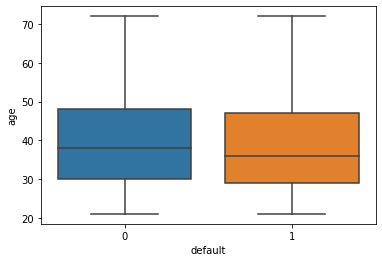

In [1688]:
display(outliers(train, 'age'))
_ = sns.boxplot(x='default', y='age', data=train)

In [1689]:
# Вроде выбросов нет - оставляем

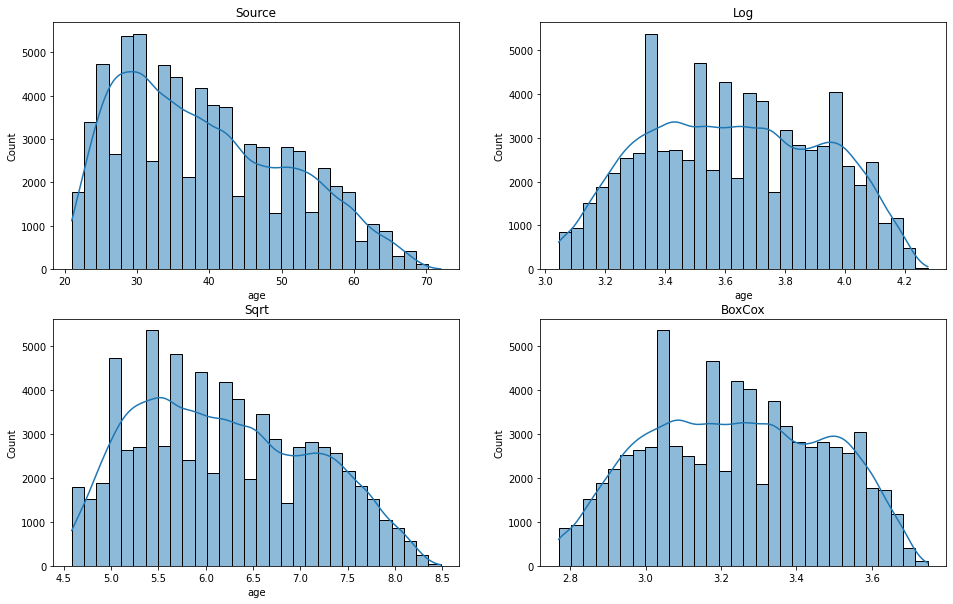

In [1690]:
# У age большой правый хвост - попробуем исправить 
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
ax[0][0].set_title('Source')
_ = sns.histplot(train['age'], fill=True, kde=True, bins=30, ax=ax[0][0])
ax[0][1].set_title('Log')
_ = sns.histplot(np.log(train['age']), fill=True, kde=True, bins=30, ax=ax[0][1])
ax[1][0].set_title('Sqrt')
_ = sns.histplot(np.sqrt(train['age']), fill=True, kde=True, bins=30, ax=ax[1][0])
ax[1][1].set_title('BoxCox')
_ = sns.histplot(stats.boxcox(train['age'])[0], fill=True, kde=True, bins=30, ax=ax[1][1])


In [1691]:
print('normality =', stats.normaltest(np.log(train['age'])))
stat, p = stats.shapiro(train['age'].sample(5000)) # тест Шапиро-Уилк
print('Шапиро-Уилк = Statistics=%.3f, p-value=%.10f' % (stat, p))

normality = NormaltestResult(statistic=15613.197409088569, pvalue=0.0)
Шапиро-Уилк = Statistics=0.958, p-value=0.0000000000


In [1692]:
# После логарифмирования стало больше похоже на нормальное, но все равно далеко от него

### Car и car_type

In [1693]:
train[(train['car'] == 'N') & (train['car_type'] == 'Y')]
# Клиентов у которых нет машины и одновременно есть иномарка нет - не все в порядке

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default


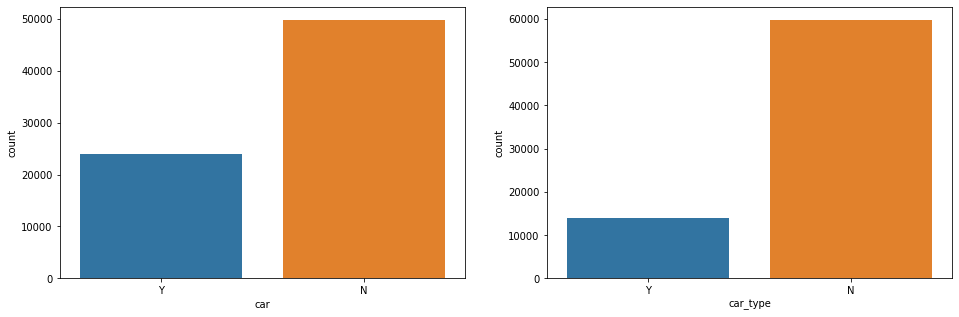

In [1694]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
_ = sns.countplot(x='car', data=train)
plt.subplot(122)
_ = sns.countplot(x='car_type', data=train)

In [1695]:
# Посмотрим на числовые значения корреляции
temp = train[['car', 'car_type']].copy()
temp['car'] = LabelEncoder().fit_transform(temp['car'])
temp['car_type'] = LabelEncoder().fit_transform(temp['car_type'])
temp.corr()

,car,car_type
car,1.000000,0.697939
car_type,0.697939,1.000000


### Decline_app_cnt

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0, Границы выбросов: [0.0, 0.0]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
8,38424,2014-02-14,SCH,F,50,Y,N,1,0,-1.676061,0,50,1,1,30000,1,4,N,0
10,26995,2014-02-03,UGR,M,50,Y,N,2,0,-1.700105,1,80,2,3,60000,1,4,Y,0
33,24303,2014-01-31,UGR,M,26,N,N,2,0,-1.109779,1,80,2,3,70000,1,4,Y,0
38,74699,2014-03-22,GRD,F,26,N,N,1,0,-1.240889,0,80,1,3,26000,1,3,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73757,31552,2014-02-07,SCH,M,37,Y,N,2,0,-2.377837,2,70,2,3,28000,1,2,N,0
73762,84655,2014-04-01,SCH,F,49,N,N,1,0,-2.615974,2,50,2,3,15000,4,2,N,0
73771,71933,2014-03-19,SCH,F,31,N,N,3,0,-1.212728,12,50,1,1,70000,1,3,Y,0
73776,104725,2014-04-23,UGR,M,30,N,N,4,0,-1.600018,1,50,2,3,32000,4,2,N,0


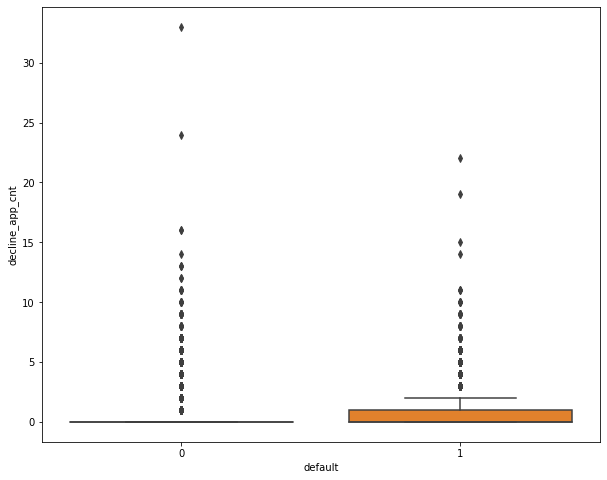

In [1696]:
display(outliers(train, 'decline_app_cnt'))
plt.figure(figsize=(10, 8))
_ = sns.boxplot(x='default', y='decline_app_cnt', data=train)

In [1697]:
# Очень много нулевых значений приводит к тому что все остальные помечаются как выбросы

<AxesSubplot:>

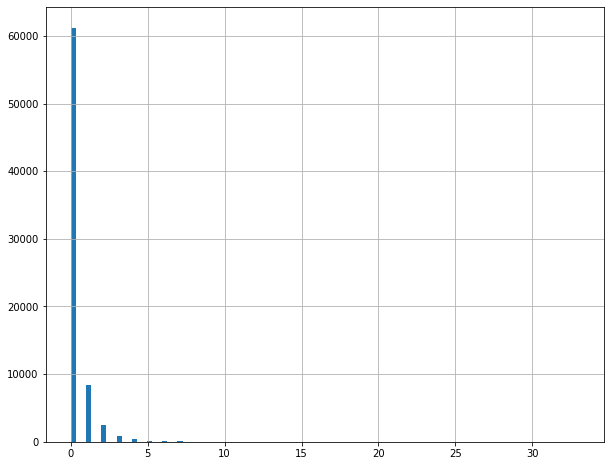

In [1698]:
plt.figure(figsize=(10, 8))
train['decline_app_cnt'].hist(bins=100)

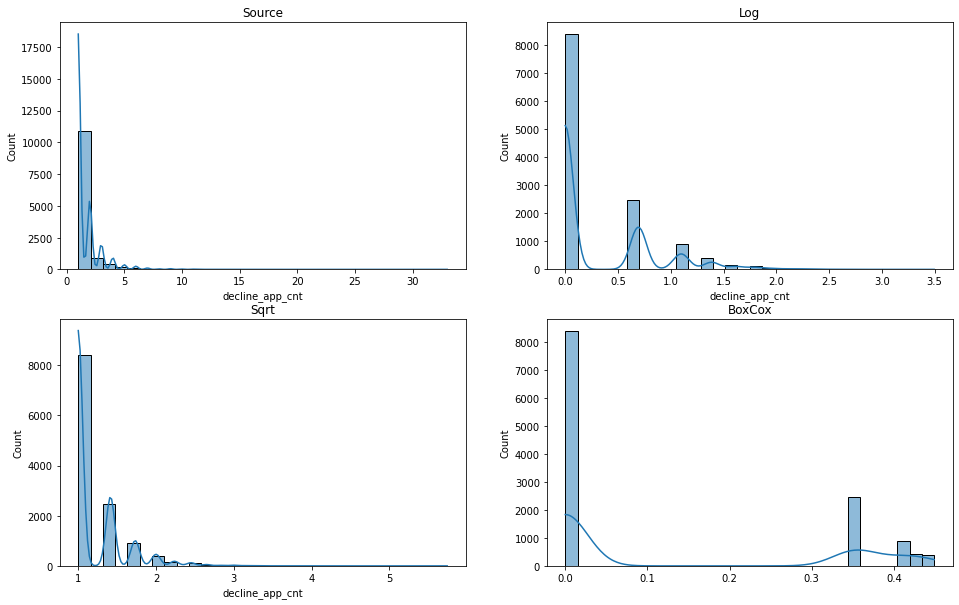

In [1699]:
# У age большой правый хвост - попробуем исправить 
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
indices = train['decline_app_cnt'] > 0
ax[0][0].set_title('Source')
_ = sns.histplot(train.loc[indices, 'decline_app_cnt'], fill=True, kde=True, bins=30, ax=ax[0][0])
ax[0][1].set_title('Log')
_ = sns.histplot(np.log(train.loc[indices, 'decline_app_cnt']), fill=True, kde=True, bins=30, ax=ax[0][1])
ax[1][0].set_title('Sqrt')
_ = sns.histplot(np.sqrt(train.loc[indices, 'decline_app_cnt']), fill=True, kde=True, bins=30, ax=ax[1][0])
ax[1][1].set_title('BoxCox')
_ = sns.histplot(stats.boxcox(train.loc[indices, 'decline_app_cnt'])[0], fill=True, kde=True, bins=30, ax=ax[1][1])

In [1700]:
# После преобразований лучше не стало

In [1701]:
# Посмотрим есть ли влияние этих признаков на целевую переменную
f, p = f_classif(train[['decline_app_cnt']], train['default'])
print(f'F-statistic = {f[0]}, p-value = {p[0]}')

F-statistic = 966.2069748841786, p-value = 9.209168013654577e-211


<AxesSubplot:>

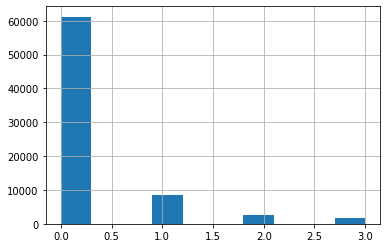

In [1702]:
# Можно попробовать сгруппировать отказы 0, 1, 2, >2
temp = train['decline_app_cnt'].apply(
    lambda x: 0 if x == 0 else 1 if x == 1 else 2 if x == 2 else 3)
#_ = sns.countplot(data=temp)
temp.hist()

### Home_address и work_address

<AxesSubplot:>

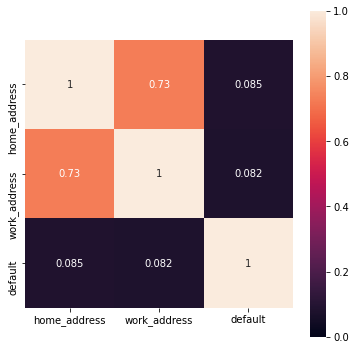

In [1703]:
# В профайлере обнаружена корреляция между нome_address и work_address, посмотрим подробнее
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(train[['home_address', 'work_address', 'default']].corr().abs(), vmin=0, vmax=1, annot=True, square=True)

In [1704]:
# Возможно следует исключить work_address ?

### Bki_request_cnt

25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0, Границы выбросов: [-4.5, 7.5]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
54,24780,2014-01-31,GRD,F,36,Y,Y,0,0,-1.801896,8,60,1,1,200000,1,3,Y,0
107,63971,2014-03-13,SCH,M,39,Y,Y,0,0,-2.363507,13,80,2,3,65000,1,4,Y,0
114,30379,2014-02-06,UGR,F,39,Y,Y,0,0,-1.461151,8,80,2,3,70000,1,3,Y,0
185,7335,2014-01-14,SCH,F,56,N,N,2,0,-0.908905,13,50,2,3,27000,4,2,N,0
188,109335,2014-04-30,GRD,M,36,Y,Y,0,0,-2.421236,10,60,2,3,75000,2,3,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73334,49727,2014-02-26,SCH,F,48,N,N,0,0,-1.477164,11,60,2,3,20000,1,3,N,1
73412,56492,2014-03-05,SCH,F,56,N,N,3,0,-0.589186,28,50,1,2,27000,1,4,N,0
73461,2870,2014-01-08,SCH,M,47,N,N,4,0,-1.534407,23,50,1,3,24000,1,4,N,0
73679,61859,2014-03-11,SCH,F,28,N,N,7,0,-2.068988,8,50,3,3,30000,1,3,Y,0


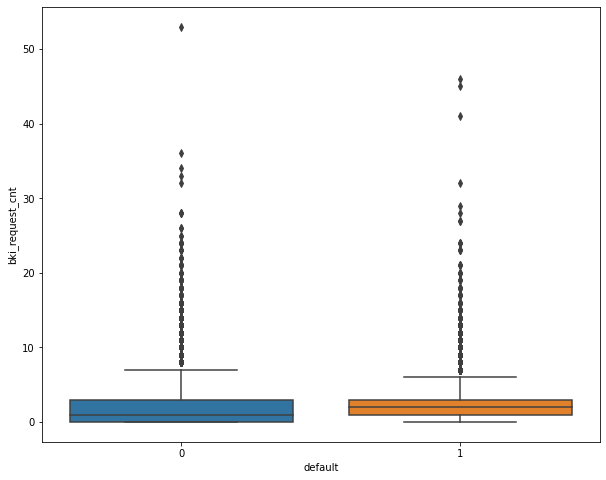

In [1705]:
display(outliers(train, 'bki_request_cnt'))
plt.figure(figsize=(10, 8))
_ = sns.boxplot(x='default', y='bki_request_cnt', data=train)

In [1706]:
# Очень много нулевых значений приводит к тому что все остальные помечаются как выбросы

In [1707]:
# Посмотрим есть ли влияние этих признаков на целевую переменную
f, p = f_classif(train[['bki_request_cnt']], train['default'])
print(f'F-statistic = {f[0]}, p_value = {p[0]}')

F-statistic = 454.55578643415953, p_value = 1.4816351290098387e-100


<AxesSubplot:>

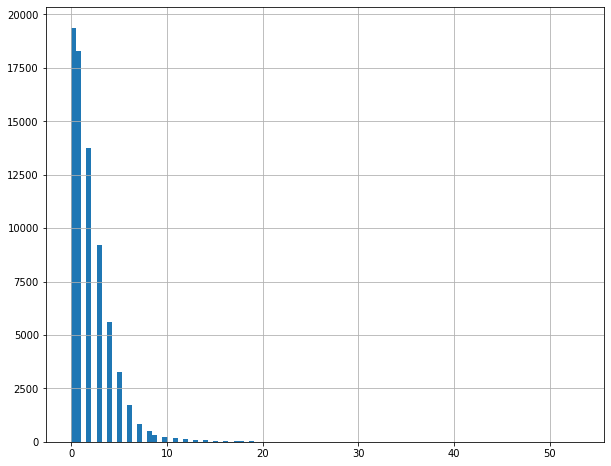

In [1708]:
plt.figure(figsize=(10, 8))
train['bki_request_cnt'].hist(bins=100)

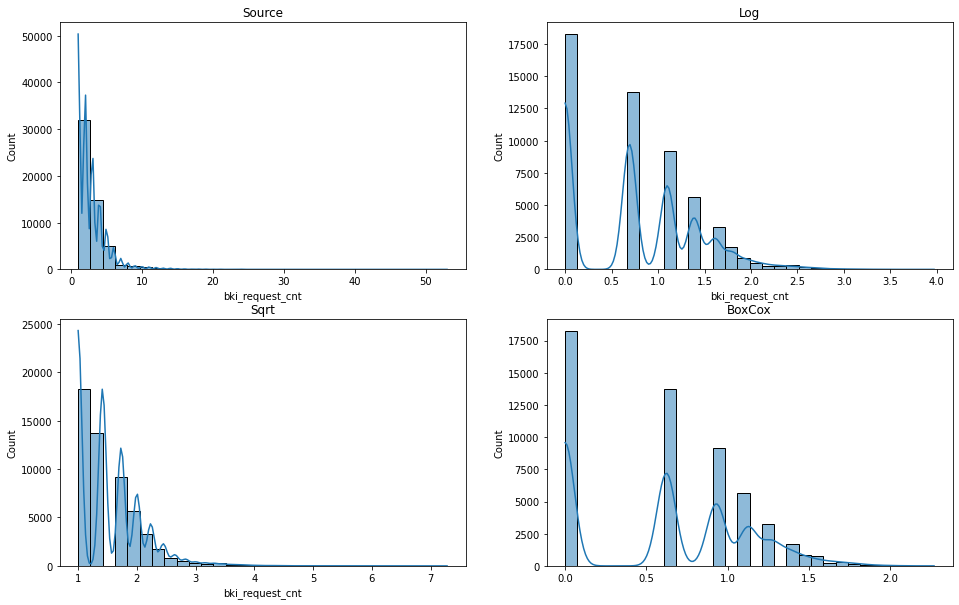

In [1709]:
# У признака большой правый хвост - попробуем исправить 
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
indices = train['bki_request_cnt'] > 0
ax[0][0].set_title('Source')
_ = sns.histplot(train.loc[indices, 'bki_request_cnt'], fill=True, kde=True, bins=30, ax=ax[0][0])
ax[0][1].set_title('Log')
_ = sns.histplot(np.log(train.loc[indices, 'bki_request_cnt']), fill=True, kde=True, bins=30, ax=ax[0][1])
ax[1][0].set_title('Sqrt')
_ = sns.histplot(np.sqrt(train.loc[indices, 'bki_request_cnt']), fill=True, kde=True, bins=30, ax=ax[1][0])
ax[1][1].set_title('BoxCox')
_ = sns.histplot(stats.boxcox(train.loc[indices, 'bki_request_cnt'])[0], fill=True, kde=True, bins=30, ax=ax[1][1])

In [1710]:
# После преобразований лучше не стало

### Region_rating

25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0, Границы выбросов: [35.0, 75.0]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
10,26995,2014-02-03,UGR,M,50,Y,N,2,0,-1.700105,1,80,2,3,60000,1,4,Y,0
28,15681,2014-01-23,UGR,M,37,Y,Y,0,0,-1.740676,3,80,2,3,100000,1,3,N,0
31,98030,2014-04-15,GRD,F,28,N,N,0,1,-1.533306,4,20,2,3,15000,1,2,N,0
33,24303,2014-01-31,UGR,M,26,N,N,2,0,-1.109779,1,80,2,3,70000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73784,64821,2014-03-13,GRD,F,27,Y,N,0,1,-1.799735,6,80,2,3,80000,1,4,Y,0
73786,41091,2014-02-17,GRD,F,51,N,N,0,0,-1.259001,4,30,2,3,15000,1,3,N,1
73792,82387,2014-03-30,UGR,F,37,Y,N,0,0,-2.157530,1,80,2,3,45000,1,2,Y,0
73793,6266,2014-01-13,SCH,F,48,N,N,0,0,-1.470891,0,80,2,3,35000,1,4,Y,0


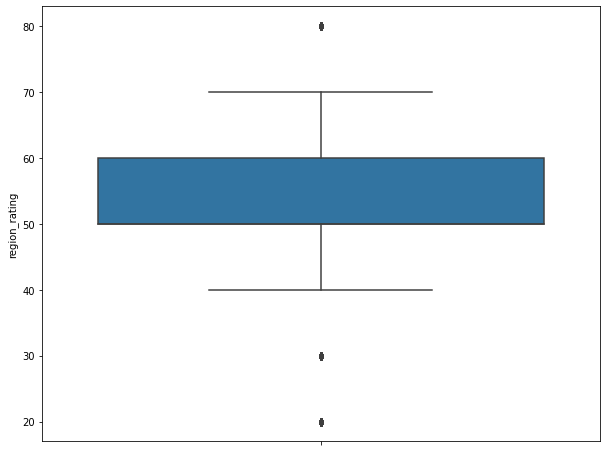

In [1711]:
display(outliers(train, 'region_rating'))
#_ = sns.boxplot(x='default', y='region_rating', data=train)
plt.figure(figsize=(10, 8))
_ = sns.boxplot(y='region_rating', data=train)

In [1712]:
#  Есть выбросы, но скорее всего крайние значения как раз сильно влияют на дефолт, оставляем как есть

In [1713]:
# Посмотрим есть ли влияние этих признаков на целевую переменную
f, p = f_classif(train[['region_rating']], train['default'])
print(f'F-statistic = {f[0]}, p_value = {p[0]}')

F-statistic = 589.6783810095484, p_value = 9.538196611988627e-130


### Income

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0, Границы выбросов: [-22000.0, 90000.0]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
28,15681,2014-01-23,UGR,M,37,Y,Y,0,0,-1.740676,3,80,2,3,100000,1,3,N,0
54,24780,2014-01-31,GRD,F,36,Y,Y,0,0,-1.801896,8,60,1,1,200000,1,3,Y,0
67,18358,2014-01-25,GRD,F,30,Y,Y,0,0,-2.000578,3,60,2,1,130000,1,3,N,0
72,53637,2014-03-02,SCH,F,27,N,N,0,1,-1.774092,0,40,2,3,350000,1,3,N,0
76,57757,2014-03-06,GRD,M,40,Y,N,0,1,-2.143950,0,50,1,1,100000,3,3,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73731,89476,2014-04-06,GRD,F,53,Y,Y,0,0,-2.022001,2,60,2,3,200000,1,4,N,0
73739,48556,2014-02-25,GRD,F,35,N,N,0,0,-1.839626,6,50,2,3,120000,1,2,N,1
73740,23484,2014-01-30,GRD,F,38,Y,Y,0,1,-1.077477,1,80,2,3,200000,1,3,N,0
73749,10628,2014-01-17,UGR,F,29,N,N,0,0,-2.134235,4,80,2,3,120000,1,3,N,0


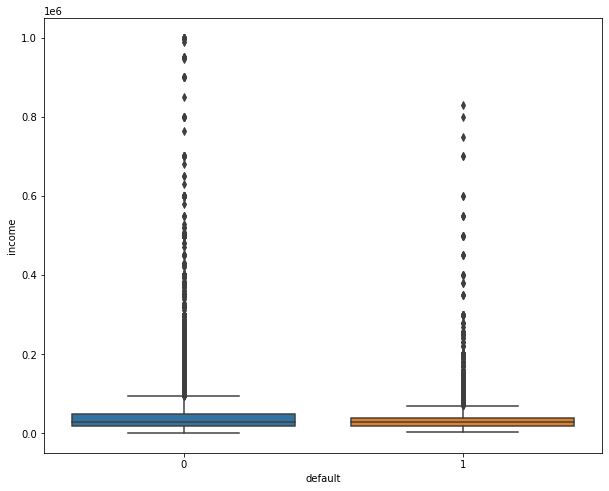

In [1714]:
display(outliers(train, 'income'))
plt.figure(figsize=(10, 8))
_ = sns.boxplot(x='default', y='income', data=train)

In [1715]:
# Выбросов много, но определить где начинается и заканчивается реальный доход очень тяжело. 
# Скорее всего доход 1000 (вопрос чего) - это действитель неправдоподобно мало, 
# а доход ровно 999999 выглядит странно, но возможно это тоже индикатор для принятия решений
# Если можно было-бы узнать как получены эти данные

In [1716]:
# Посмотрим есть ли влияние этих признаков на целевую переменную
f, p = f_classif(train[['income']], train['default'])
print(f'F-statistic = {f[0]}, p_value = {p[0]}')

F-statistic = 116.79801365748176, p_value = 3.3312352190447544e-27


<AxesSubplot:>

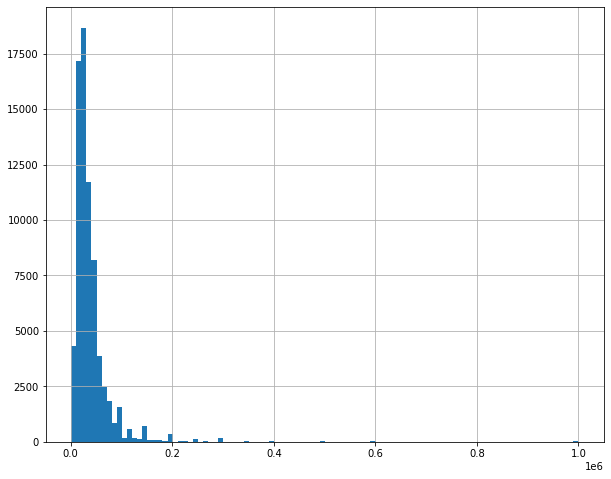

In [1717]:
plt.figure(figsize=(10, 8))
train['income'].hist(bins=100)

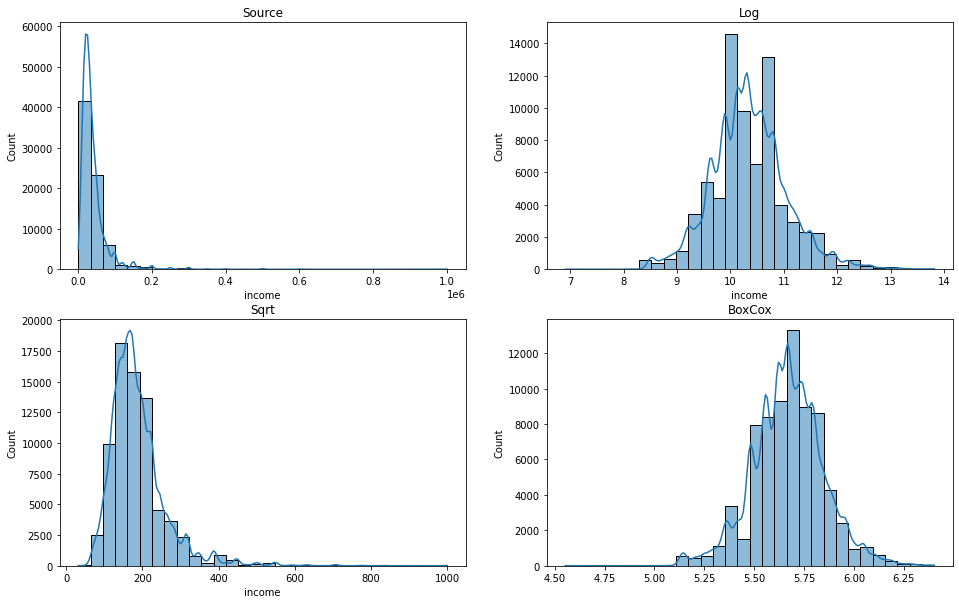

In [1718]:
# У признака большой правый хвост - попробуем исправить 
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
indices = train['income'] > 0
ax[0][0].set_title('Source')
_ = sns.histplot(train.loc[indices, 'income'], fill=True, kde=True, bins=30, ax=ax[0][0])
ax[0][1].set_title('Log')
_ = sns.histplot(np.log(train.loc[indices, 'income']), fill=True, kde=True, bins=30, ax=ax[0][1])
ax[1][0].set_title('Sqrt')
_ = sns.histplot(np.sqrt(train.loc[indices, 'income']), fill=True, kde=True, bins=30, ax=ax[1][0])
ax[1][1].set_title('BoxCox')
_ = sns.histplot(stats.boxcox(train.loc[indices, 'income'])[0], fill=True, kde=True, bins=30, ax=ax[1][1])

In [1719]:
# После логарифма и бокса-кокса стало гораздо лучше

### SNA

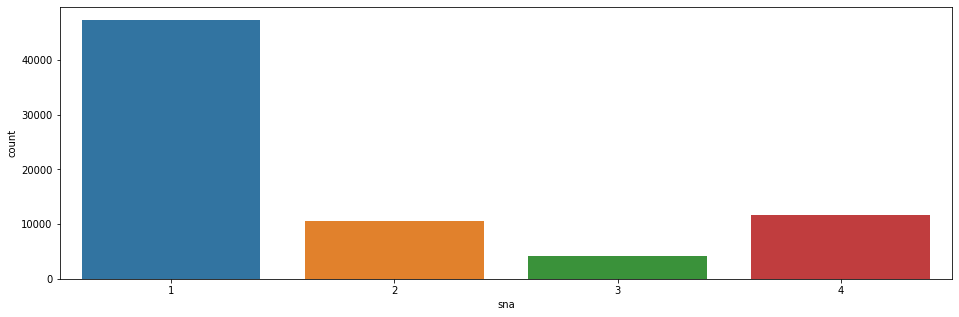

In [1720]:
# Вообще непонятный параметр. Что означает "связь заемщика с клиентами банка"? 
# Сколько человек? Балльная оценка? Если баллы что лучше 1 или 4?
# Будем рассматривать как баллы
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='sna', data=train)

<AxesSubplot:>

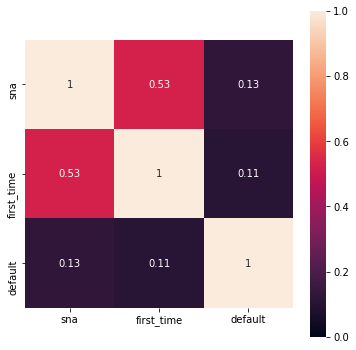

In [1721]:
# Интересна обратная корреляция между sna и first_time
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(train[['sna', 'first_time', 'default']].corr().abs(), vmin=0, vmax=1, annot=True, square=True)

### First_time

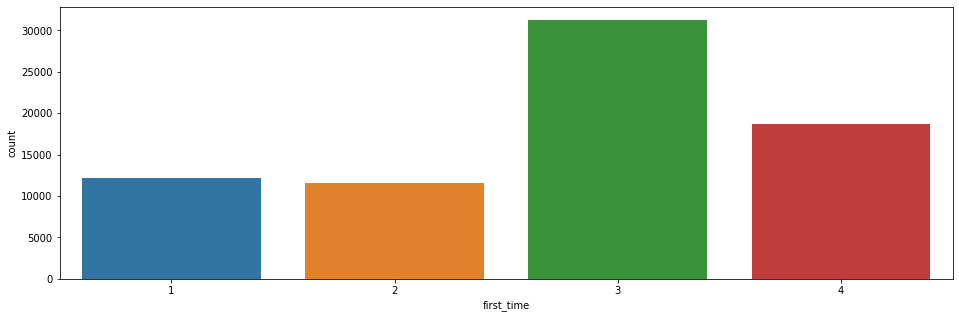

In [1722]:
# Тоже непонятный признак "давность наличия информации о заемщике".
# Но здесь скорее всего категория 1 - небольшая давность, 4 - большая
# Тогда можно объяснить корреляцию (чем меньше давность, тем больше связь с клиентами)
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='first_time', data=train)

### И на "сладкое" default

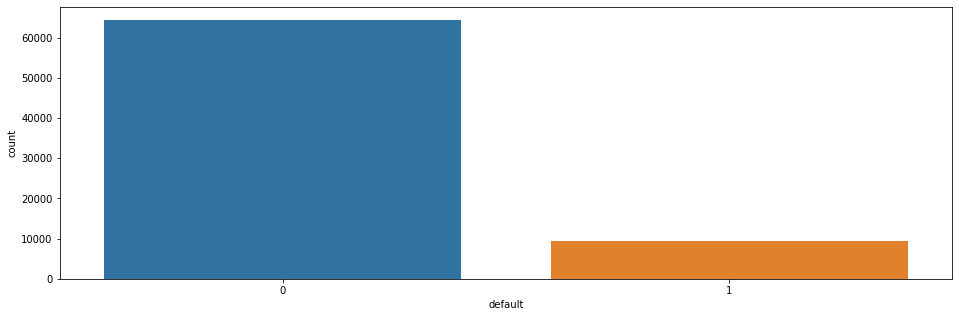

In [1723]:
# Из профайлера видно, что есть большой перекос в данных. Не 10 к одному, но 87 к 13 тоже много.
# Надо будет учитывать при построении модели
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='default', data=train)

In [1724]:
len(train[train['default'] == 1]) / len(train[train['default'] == 0])

0.14546696260884412

## Предобработка

In [1725]:
# Заполнить пропуски в education = 'UNK'
train['education'].fillna('UNK', inplace=True)
train['education'].value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
UNK      307
ACD      194
Name: education, dtype: int64

In [1726]:
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
53238,40694,2014-02-17,SCH,F,66,N,N,0,0,-2.303874,2,50,2,3,14000,1,3,N,0
7392,57851,2014-03-06,SCH,M,42,Y,N,0,0,-2.466902,0,50,1,1,12000,1,4,N,0
49622,102443,2014-04-20,GRD,F,25,N,N,0,1,-1.631889,3,80,1,3,40000,1,4,Y,0
22962,82617,2014-03-31,GRD,F,37,N,N,0,0,-2.124597,0,60,1,1,22000,1,3,N,0
31717,24876,2014-01-31,SCH,F,45,N,N,1,0,-1.469545,1,60,1,2,20000,2,2,N,1


In [1727]:
def boxcox(df):
    boxcox_df = df.copy()
    for f in df.columns:
        zero_indices = df[f] == 0
        bc, lam = stats.boxcox(df.loc[df[f] > 0, f])
        boxcox_df.loc[~zero_indices, f] = bc
        boxcox_df.loc[zero_indices, f] = -1 / lam
    return boxcox_df    


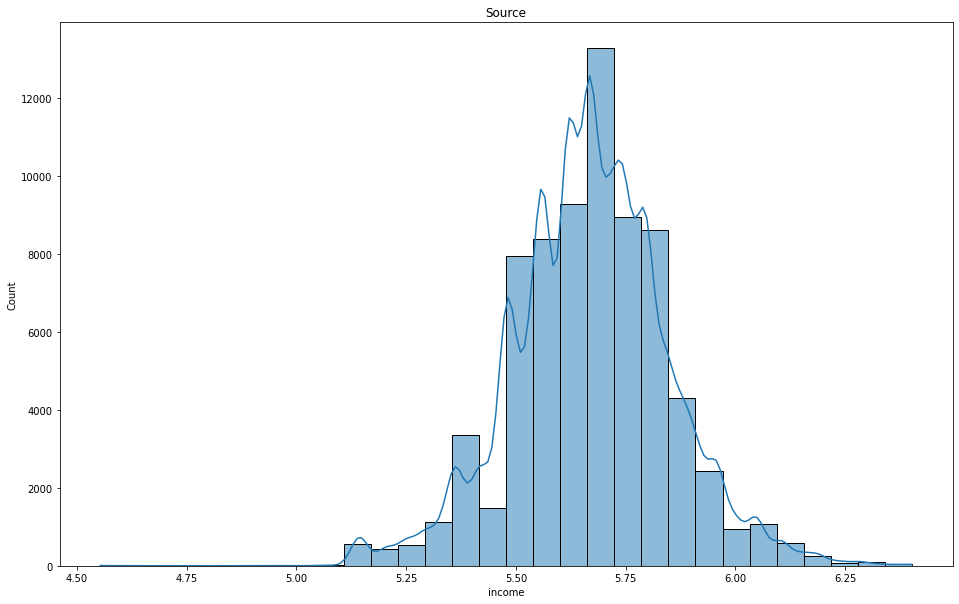

In [1728]:
# У income большой правый хвость применим преобразование Бокса-Кокса к признаку
train['income'] = boxcox(train[['income']])
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.set_title('Source')
_ = sns.histplot(train['income'], fill=True, kde=True, bins=30, ax=ax)

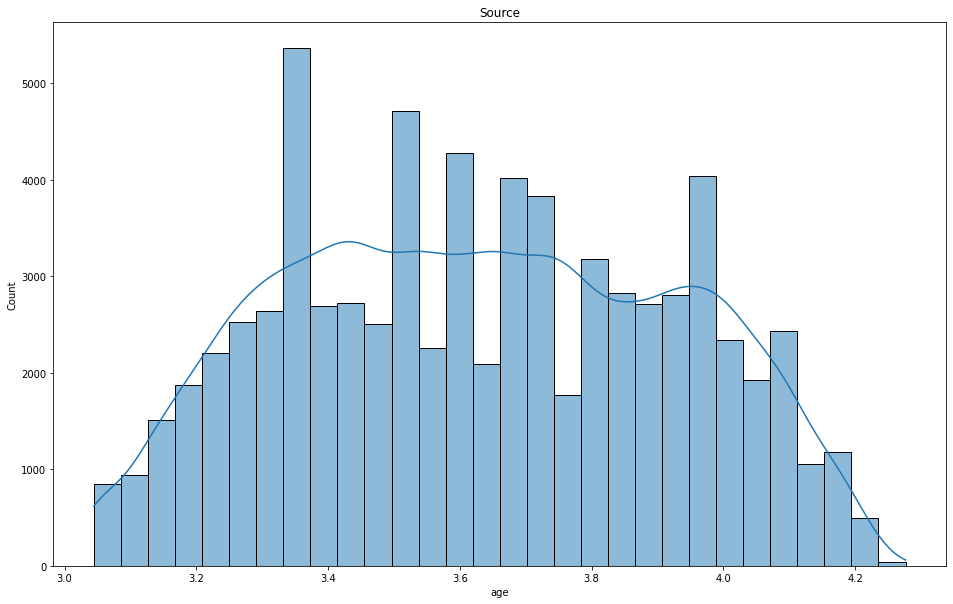

In [1729]:
# У age большой правый хвость применим преобразование логарифмирование к признаку
train['age'] = np.log(train['age'])
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.set_title('Source')
_ = sns.histplot(train['age'], fill=True, kde=True, bins=30, ax=ax)

### Feature engineering

In [1730]:
num_features = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
bin_features = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_features = ['education', 'work_address', 'home_address']
ord_features = ['sna', 'first_time', 'region_rating']
del_features = ['client_id', 'app_date']
target = 'default'
len(num_features + bin_features + cat_features + ord_features + del_features + [target])

19

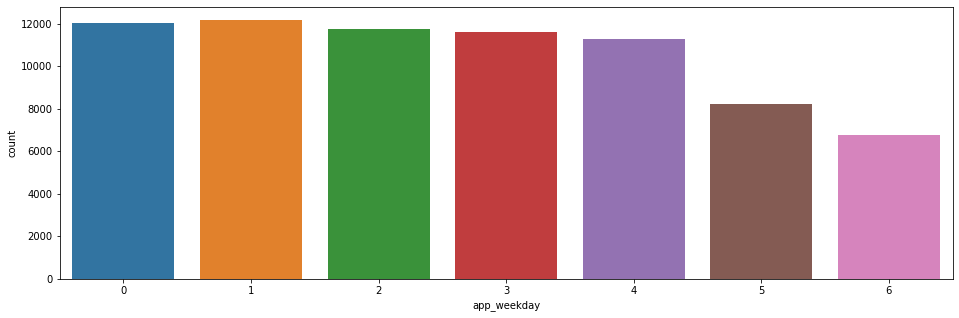

In [1731]:
train['app_weekday'] = train['app_date'].dt.weekday
cat_features.append('app_weekday')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='app_weekday', data=train)

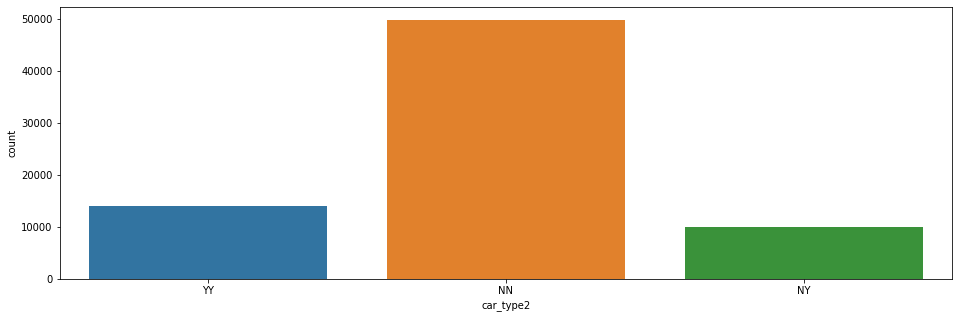

In [1732]:
train['car_type2'] = train['car_type'] + train['car']
cat_features.append('car_type2')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='car_type2', data=train)

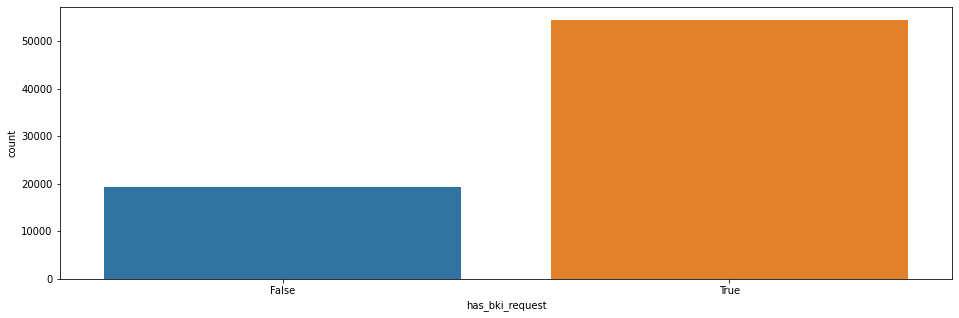

In [1733]:
train['has_bki_request'] = train['bki_request_cnt'] > 0
bin_features.append('has_bki_request')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='has_bki_request', data=train)

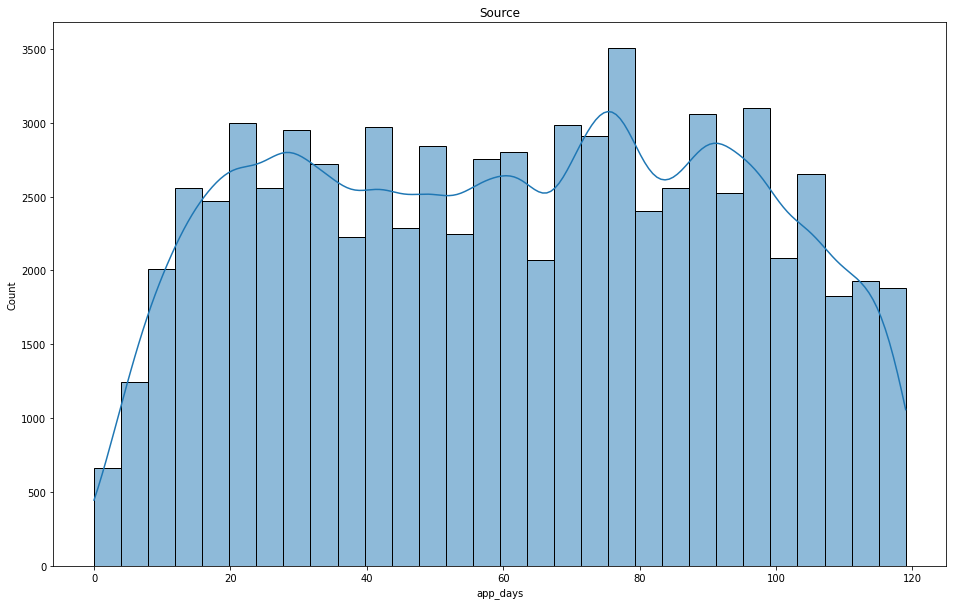

In [1734]:
train['app_days'] = (train['app_date'] - datetime(2014, 1, 1)).dt.days
num_features.append('app_days')
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.set_title('Source')
_ = sns.histplot(train['app_days'], fill=True, kde=True, bins=30, ax=ax)

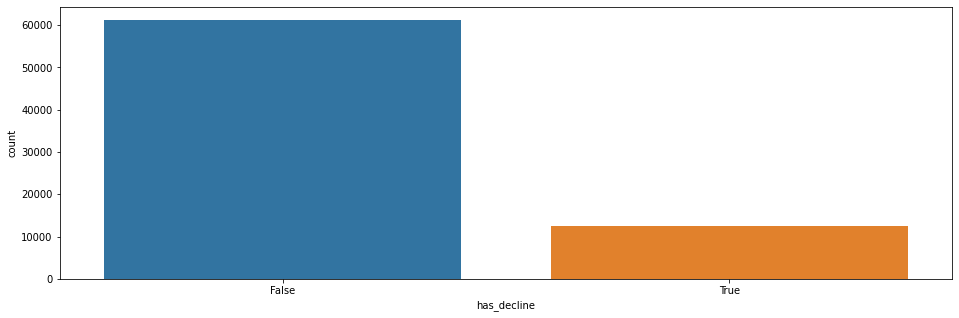

In [1735]:
train['has_decline'] = train['decline_app_cnt'] > 0
bin_features.append('has_decline')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='has_decline', data=train)

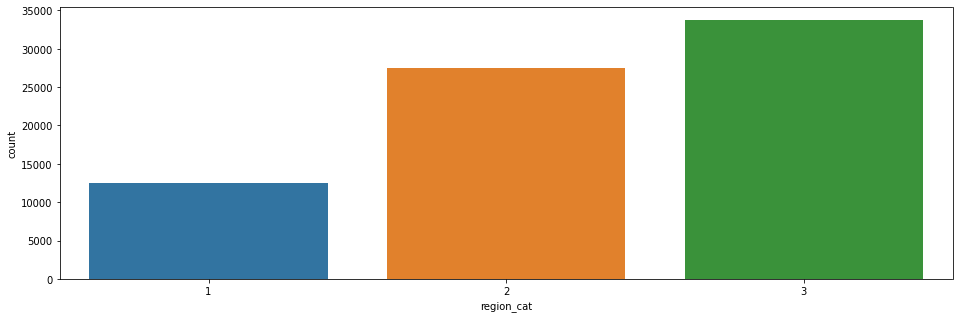

In [1736]:
train['region_cat'] = train['region_rating'].apply(lambda x: 2 if x == 50 else 1 if x < 50 else 3)
cat_features.append('region_cat')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='region_cat', data=train)


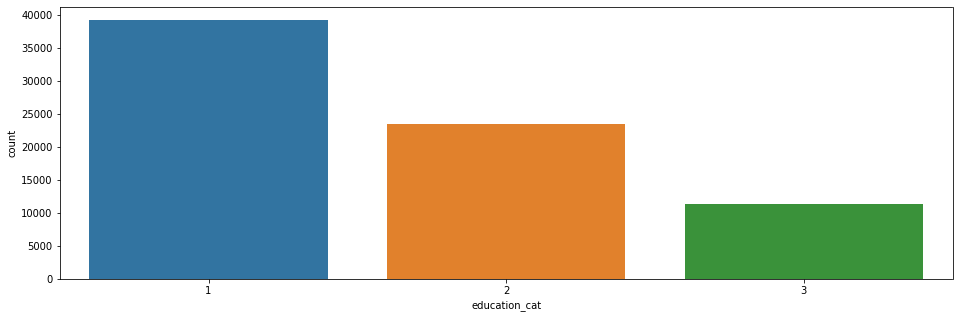

In [1737]:
edu_map = {'UNK': 1, 'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 3, 'ACD': 3}
train['education_cat'] = train['education'].map(edu_map)
cat_features.append('education_cat')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='education_cat', data=train)


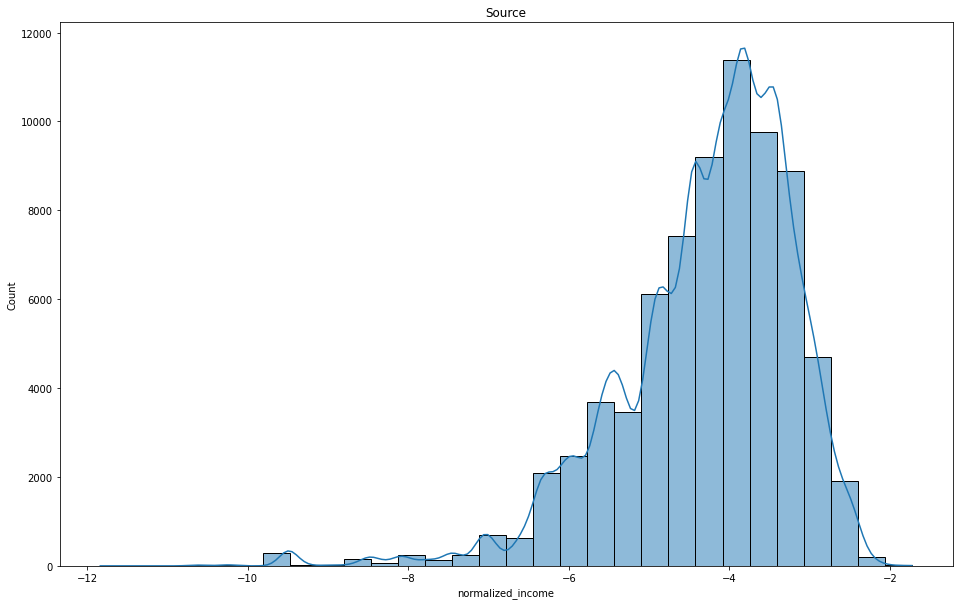

In [1738]:
mean_income = train.groupby('age')['income'].mean().to_dict()
mean_income_age = train['age'].map(mean_income)
max_income = train.groupby('age')['income'].max().to_dict()
max_income_age = train['age'].map(max_income)        
train['normalized_income'] = np.log(abs((train.income - mean_income_age) / max_income_age))
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.set_title('Source')
_ = sns.histplot(train['normalized_income'], fill=True, kde=True, bins=30, ax=ax)

### Feature selection

In [1739]:
train.set_index('client_id', inplace=True)

In [1740]:
train.sample(2)

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,foreign_passport,default,app_weekday,car_type2,has_bki_request,app_days,has_decline,region_cat,education_cat,normalized_income
client_id,,,,,,,,,,,,,,,,,,,,,
87115,2014-04-03,GRD,M,3.465736,N,N,2,0,-1.207736,4,...,N,0,3,NN,True,92,True,2,2,-5.661678
91452,2014-04-08,SCH,M,3.332205,N,N,0,1,-1.441151,0,...,N,1,1,NN,False,97,False,1,1,-4.616520


In [1741]:
def showImportance(features_imp, features, n=20):
    imp_df = pd.DataFrame(features_imp.T, columns=['importance'], index=features)
    imp_df = np.abs(imp_df)
    imp_df = imp_df.sort_values(by='importance', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)
    df4display = imp_df.head(n)
    sns.barplot(x=df4display['importance'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


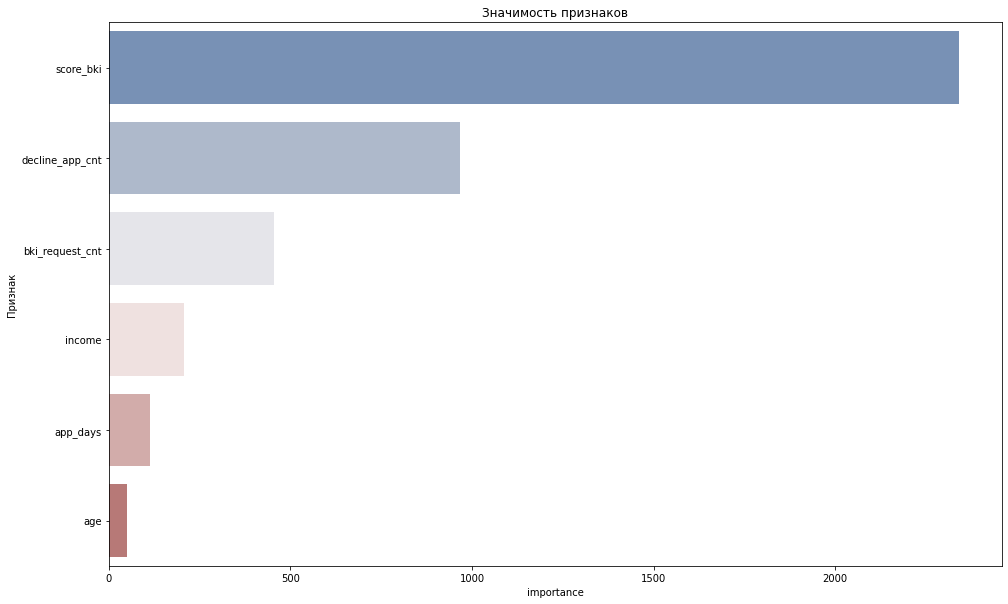

In [1742]:
f_cls = f_classif(train[num_features], train['default'])
showImportance(f_cls[0], num_features)

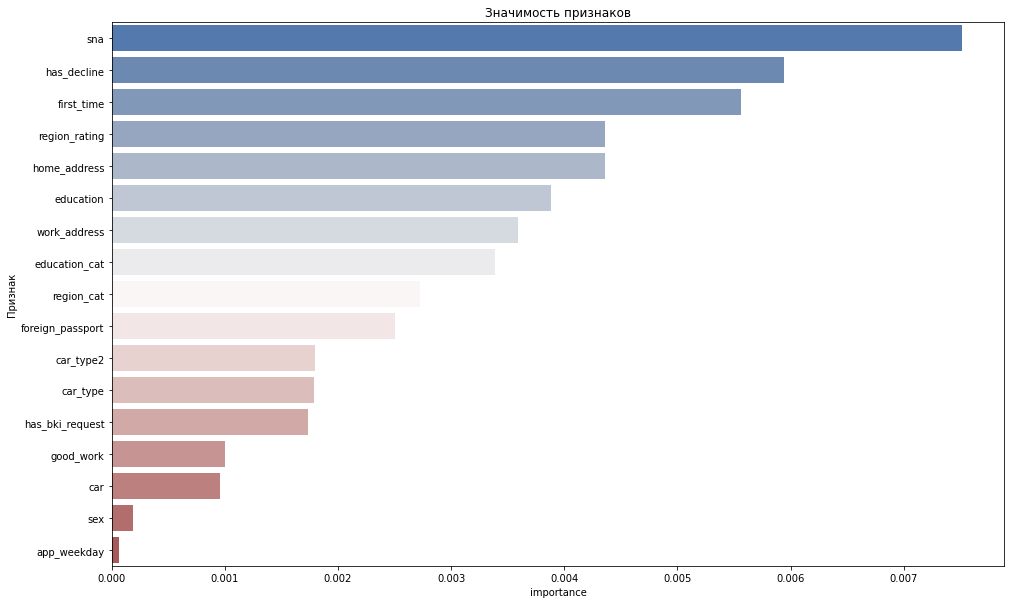

In [1743]:
temp_df = train[bin_features + cat_features + ord_features + ['default']].copy()
label_encoder = LabelEncoder()
for feature in bin_features + cat_features:
    temp_df[feature] = label_encoder.fit_transform(train[feature])
mis = mutual_info_classif(temp_df[bin_features + cat_features + ord_features], 
                          temp_df['default'], discrete_features=True)
showImportance(mis, bin_features + cat_features + ord_features)

### Check correlation

In [1744]:
# Корреляция между числовыми признаками набора данных
def showNumCorr(df, features, title='Корреляция между данными'):
    # Корреляция между данными о ролике
    plt.figure(figsize=(16, 10))
    mask = np.triu(np.ones_like(df[features].corr(), dtype=bool))
    heatmap = sns.heatmap(df[features].corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)    
    return heatmap

Text(0.5, 1.0, 'Корреляция между данными')

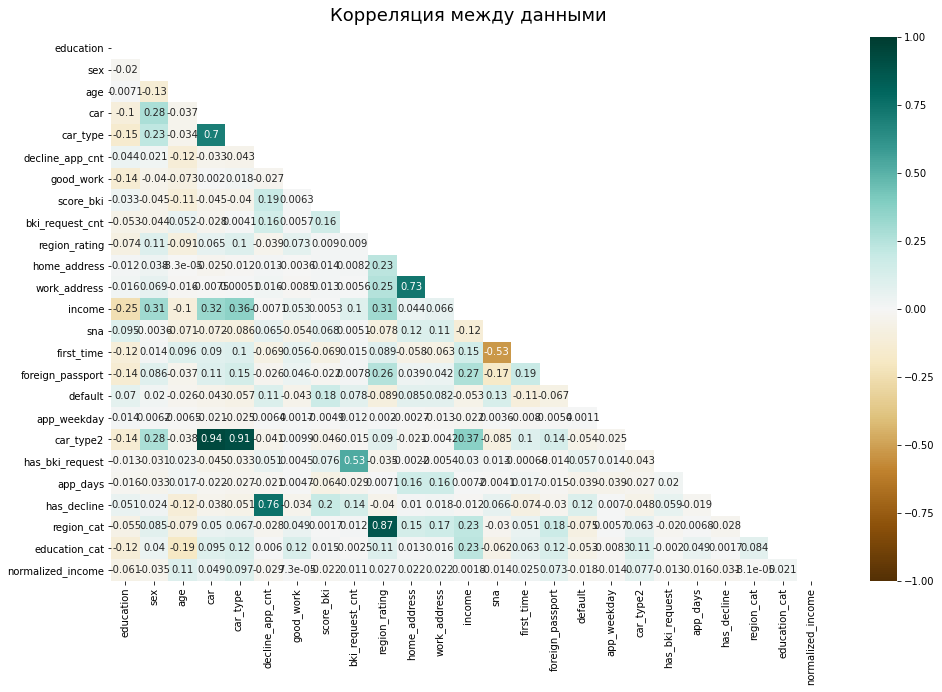

In [1745]:
temp_df = train.copy()
temp_df.drop('app_date', axis=1, inplace=True)
label_encoder = LabelEncoder()
for feature in bin_features + cat_features:
    temp_df[feature] = label_encoder.fit_transform(train[feature])
showNumCorr(temp_df, temp_df.columns)

In [1746]:
# Получили значительную корреляцию car_type2 c car и car_type
train.drop(['car', 'car_type'], axis=1, inplace=True, errors='ignore')
if 'car' in bin_features:
    bin_features.remove('car') 
if 'car_type' in bin_features:
    bin_features.remove('car_type') 
# и region_rating c region_cat при этом все таки region_rating все таки больше влияет на default
train.drop(['region_cat'], axis=1, inplace=True, errors='ignore')
if 'region_cat' in cat_features:
    cat_features.remove('region_cat') 

In [1747]:
### Features preparing

In [1748]:
# Binary features encode
label_encoder = LabelEncoder()
for feature in bin_features:
    train[feature] = label_encoder.fit_transform(train[feature])
train.sample(2)

,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,first_time,foreign_passport,default,app_weekday,car_type2,has_bki_request,app_days,has_decline,education_cat,normalized_income
client_id,,,,,,,,,,,,,,,,,,,,,
7990,2014-01-15,GRD,0,3.610918,9,0,-1.323792,6,40,2,...,2,0,0,2,NN,1,14,1,2,-4.133125
67997,2014-03-17,SCH,0,3.526361,0,0,-1.458140,1,60,1,...,3,0,0,0,NN,1,75,0,1,-5.564289


In [1749]:
# Categorical features encode
onehot_encoder = OneHotEncoder(sparse = False, handle_unknown='ignore')
onehot_encoder = onehot_encoder.fit(train[cat_features])
df = pd.DataFrame(onehot_encoder.transform(train[cat_features]), 
                  columns=onehot_encoder.get_feature_names(input_features=cat_features),
                  index=train.index, dtype=int)
train = train.drop(cat_features, axis=1)
train = pd.concat([train, df], axis=1)
train.sample(2)

,app_date,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,...,app_weekday_3,app_weekday_4,app_weekday_5,app_weekday_6,car_type2_NN,car_type2_NY,car_type2_YY,education_cat_1,education_cat_2,education_cat_3
client_id,,,,,,,,,,,,,,,,,,,,,
58269,2014-03-06,0,3.496508,0,1,-1.808726,0,70,5.668952,1,...,1,0,0,0,1,0,0,1,0,0
10884,2014-01-18,0,3.663562,0,0,-2.049017,0,60,5.479840,2,...,0,0,1,0,1,0,0,1,0,0


In [1750]:
scaler = StandardScaler()
scaler.fit(train[num_features])
scaled_df = pd.DataFrame(scaler.transform(train[num_features]), 
                         columns=num_features, index=train.index)
train = train.drop(num_features, axis=1)
train = pd.concat([train, scaled_df], axis=1)
train.sample(2)

,app_date,sex,good_work,region_rating,sna,first_time,foreign_passport,default,has_bki_request,has_decline,...,car_type2_YY,education_cat_1,education_cat_2,education_cat_3,age,score_bki,decline_app_cnt,bki_request_cnt,income,app_days
client_id,,,,,,,,,,,,,,,,,,,,,
80791,2014-03-28,0,0,80,1,4,1,0,1,0,...,0,1,0,0,1.168896,1.064916,-0.342858,0.443888,0.213660,0.777188
18800,2014-01-26,1,0,80,1,1,0,0,1,0,...,0,0,0,1,-1.682022,-1.950853,-0.342858,-0.444189,0.402063,-1.121842


In [1751]:
train.drop('app_date', axis=1, inplace=True, errors='ignore')
train.sample(2)

,sex,good_work,region_rating,sna,first_time,foreign_passport,default,has_bki_request,has_decline,normalized_income,...,car_type2_YY,education_cat_1,education_cat_2,education_cat_3,age,score_bki,decline_app_cnt,bki_request_cnt,income,app_days
client_id,,,,,,,,,,,,,,,,,,,,,
44561,1,0,40,1,1,0,0,1,0,-4.507682,...,0,0,1,0,0.969902,0.506612,-0.342858,0.443888,0.402063,-0.312419
103703,1,0,50,2,4,0,0,1,1,-4.210960,...,0,1,0,0,0.032672,-0.704842,0.900511,0.443888,0.709670,1.555479


### Make base model

In [1752]:
def showImportance(model, features, n=20):
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    f, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)
    top_lr_coef = lr_coef.sort_values(by='coefficient', ascending=False).head(n)
    low_lr_coef = lr_coef.sort_values(by='coefficient', ascending=False).tail(n)
    df4display = pd.concat([top_lr_coef, low_lr_coef])
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")
    
    
def showMetrics(y_test, y_prob, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['success','default'])
    fpr, tpr, threshold = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 6)

    ax[0].plot([0, 1], label='Baseline', linestyle='--')
    ax[0].plot(fpr, tpr, label = 'Regression')
    ax[0].set_title('ROC AUC = %0.10f' % roc_auc)
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].legend(loc='lower right')

    cmd.plot(ax=ax[1])
    cmd.ax_.set(xlabel='Predicted', ylabel='True')
    plt.show()

def split(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop('default', axis=1), 
                                                    df['default'], 
                                                    test_size=0.20, 
                                                    stratify=df['default'], 
                                                    random_state=42)
    return X_train, X_test, y_train, y_test


In [1753]:
class ScorerHistory:
    scores_columns = ['estimator', 'roc_auc',
                      'accuracy', 'precision', 'recall', 'f1']
    scores_df = pd.DataFrame([], columns=scores_columns)

    def add2scores(name, y_test, y_pred, y_prob):
        df = pd.DataFrame([[name,
                            roc_auc_score(y_test, y_prob),
                            accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred),
                            f1_score(y_test, y_pred)]], columns=ScorerHistory.scores_columns)
        ScorerHistory.scores_df = pd.concat([ScorerHistory.scores_df, df], axis=0)
        return ScorerHistory.scores_df
    

class ScorerBase():
    '''
    Базовый класс для предобработки данных
    Делает кодирование, шкалирование, обучение модели и предсказания
    '''
    def __init__(self, X_train, y_train):
        self._data = X_train
        self._target = y_train
        self._features = {
            'num': ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income'],
            'cat': ['education', 'work_address', 'home_address'],
            'ord': ['region_rating', 'first_time', 'sna'],
            'bin': ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
        }
        
        
    def prepare(self, df, features):
        new_features = copy.deepcopy(features)
        columns = []
        for v in new_features.values():
            for f in v:
                columns.append(f)
        new_df = df.copy(columns)
        # Clean data
        new_df['education'].fillna('SCH', inplace=True)
        # Дата представлена в формате %d%b%Y - сразу переведем в тип datetime
        new_df['app_date'] = pd.to_datetime(data['app_date'])        
        return new_df, new_features
    
    def fit(self, df, features):
        # Fit encoders and scalers
        self._label_encoder = LabelEncoder()
        self._onehot_encoder = OneHotEncoder(sparse = False, handle_unknown='ignore')
        onehot_encoder = self._onehot_encoder.fit(df[features['cat']])
        self._num_scaler = StandardScaler()
        self._num_scaler.fit(df[features['num']])
        self._ord_scaler = StandardScaler()
        self._ord_scaler.fit(df[features['ord']])
        return self
    
    def transform(self, df, features):
        assert(self._label_encoder is not None)
        assert(self._onehot_encoder is not None)
        assert(self._num_scaler is not None)
        assert(self._ord_scaler is not None)
        new_df = pd.DataFrame([], index=df.index)
        # Binary features encode
        for feature in features['bin']:
            new_df[feature] = self._label_encoder.fit_transform(df[feature])
        # Categorical features encode
        columns = self._onehot_encoder.get_feature_names(input_features=features['cat'])
        encoded_df =  pd.DataFrame(self._onehot_encoder.transform(df[features['cat']]), 
                                   columns=columns, index=df.index, dtype=int)
        new_df = pd.concat([new_df, encoded_df], axis=1)
        # Numeric features scale
        scaled_df = pd.DataFrame(self._num_scaler.transform(df[features['num']]), 
                                 columns=features['num'], index=df.index)
        new_df = pd.concat([new_df, scaled_df], axis=1)
        # Ordered features 
#        scaled_df = pd.DataFrame(self._ord_scaler.transform(df[features['ord']]), 
#                                 columns=features['ord'], index=df.index)
        scaled_df = df[features['ord']]
        new_df = pd.concat([new_df, scaled_df], axis=1)
        return new_df
    
    def prepare_fit_transform(self):
        (df, features)  = self.prepare(self._data, self._features)
        self.fit(df, features)
        return self.transform(df, features), self._target
    
    def get_target(self):
        return self._target
    
    def train(self, model):
        self._model = model
        assert(self._model is not None)
        (df, features) = self.prepare(self._data, self._features)
        df = self.fit(df, features).transform(df, features)
        self._model.fit(df, self._target)
        return model
    
    def predict(self, test):
        assert(self._model is not None)
        (df, features) = self.prepare(test, self._features)
        df = self.transform(df, features)
        return self._model.predict(df)

    def predict_proba(self, test):
        assert(self._model is not None)
        (df, features) = self.prepare(test, self._features)
        df = self.transform(df, features)
        return self._model.predict_proba(df)[:,1]
    

,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,home_address_2,home_address_3,age,score_bki,decline_app_cnt,bki_request_cnt,income,region_rating,first_time,sna
51303,0,0,0,0,0,0,0,0,1,0,...,1,0,1.277001,-0.517049,-0.34032,2.664373,-0.045766,80,4,1
21576,0,1,1,1,1,0,0,0,1,0,...,0,0,-0.806425,-0.323289,-0.34032,0.445309,-0.131968,50,2,1
34543,1,1,1,0,0,0,0,0,1,0,...,0,0,2.058286,-0.487466,-0.34032,-0.442317,0.018886,50,4,1
51812,0,0,0,0,0,0,1,0,0,0,...,0,0,-0.893235,1.161737,-0.34032,1.776747,-0.433677,60,3,1
70952,1,0,0,0,0,0,1,0,0,0,...,1,0,-0.545997,0.307754,-0.34032,0.445309,-0.131968,50,3,1


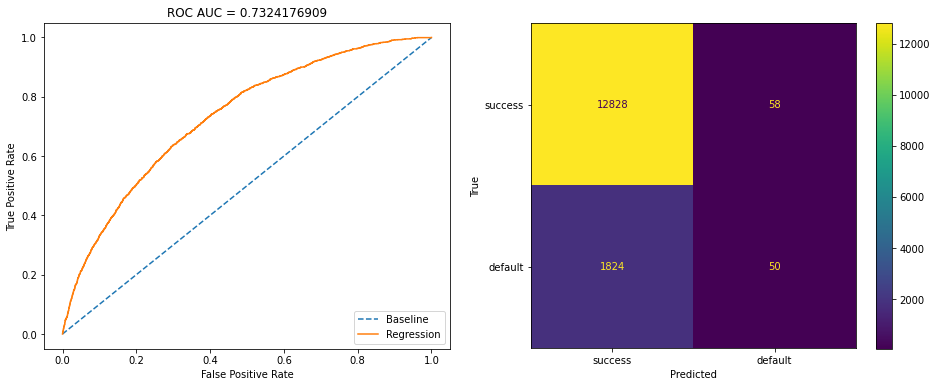

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732418,0.872493,0.462963,0.026681,0.050454


In [1754]:
# Base model
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)
scorer = ScorerBase(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
model = LogisticRegression(max_iter=1000, random_state=42)
scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('base', y_test, y_pred, y_prob)

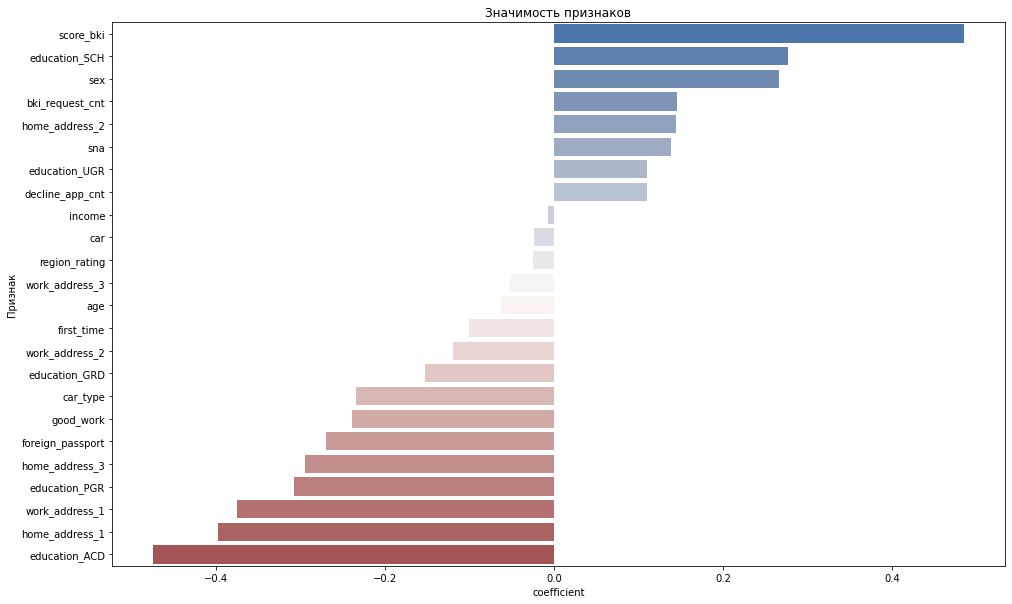

In [1755]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

In [1756]:
class ScorerGen(ScorerBase):
    '''
    Класс для предобработки данных с переопределеннм методом prepare,
    где генирируются и отбираются признаки
    '''
    
    def boxcox(self, df):
        boxcox_df = df.copy()
        for f in df.columns:
            zero_indices = df[f] == 0
            bc, lam = stats.boxcox(df.loc[df[f] > 0, f])
            boxcox_df.loc[~zero_indices, f] = bc
            boxcox_df.loc[zero_indices, f] = -1 / lam
        return boxcox_df    
    
    def prepare(self, df, features):
        (df, features) = super().prepare(df, features)
        
        # Add features
        df['income'] = self.boxcox(df[['income']])
        df['app_days'] = (df['app_date'] - datetime(2014, 1, 1)).dt.days
        features['num'].append('app_days')
        df['hw_address'] = df['home_address'] + df['work_address']
        features['ord'].append('hw_address')
        df['has_decline'] = df['decline_app_cnt'] > 0 
        features['bin'].append('has_decline')
                       
        # remove features
 
        return df, features
    
            

,sex,car,car_type,foreign_passport,good_work,has_decline,education_ACD,education_GRD,education_PGR,education_SCH,...,age,score_bki,decline_app_cnt,bki_request_cnt,income,app_days,region_rating,first_time,sna,hw_address
45912,0,1,0,0,0,0,0,0,0,1,...,1.190192,0.259323,-0.340320,-0.886130,-0.104934,0.594212,50,1,4,5
523,0,0,0,0,0,0,0,0,0,1,...,-0.198759,0.192117,-0.340320,-0.442317,0.404152,-0.433661,70,3,1,4
42270,0,0,0,0,0,0,0,0,0,1,...,1.277001,0.504512,-0.340320,0.889121,-1.415446,-0.277923,60,4,1,3
53547,0,1,1,0,0,1,0,1,0,0,...,-0.806425,1.803376,4.590868,0.001496,-0.004571,1.372905,50,3,1,5
44192,1,1,1,1,0,0,0,0,0,1,...,0.148478,-1.846913,-0.340320,-0.886130,1.606676,0.812246,50,3,1,3


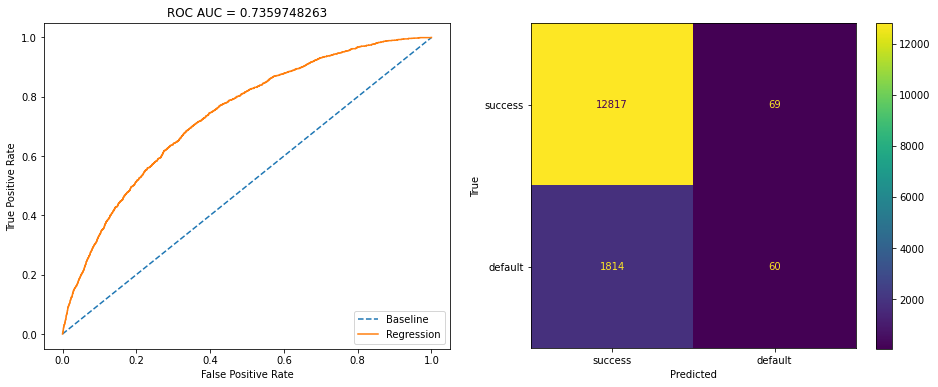

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732418,0.872493,0.462963,0.026681,0.050454
0,lr+gen,0.735975,0.872425,0.465116,0.032017,0.059910


In [1757]:
# Model with generated features
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)
scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
model = LogisticRegression(max_iter=1000, random_state=42)
scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+gen', y_test, y_pred, y_prob)

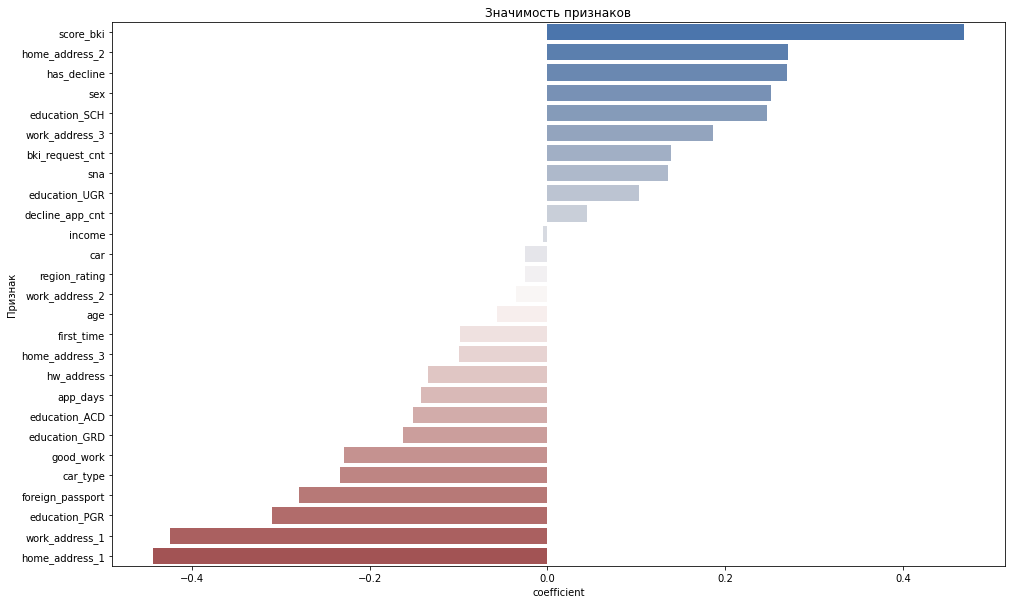

In [1758]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

,sex,car,car_type,foreign_passport,good_work,has_decline,education_ACD,education_GRD,education_PGR,education_SCH,...,age,score_bki,decline_app_cnt,bki_request_cnt,income,app_days,region_rating,first_time,sna,hw_address
17158,1,1,1,0,0,0,0,0,1,0,...,-0.893235,0.928992,-0.34032,0.889121,1.475726,-1.648421,80,4,1,5
65542,1,0,0,0,1,0,0,0,0,1,...,-1.587710,-0.401081,-0.34032,-0.886130,-0.271800,0.095849,40,3,2,4
2436,1,0,0,1,1,0,0,0,0,1,...,0.061669,1.338400,-0.34032,-0.442317,-0.271800,-1.399240,50,4,2,5
2759,0,0,0,0,0,0,0,0,0,1,...,-0.111950,-0.153258,-0.34032,-0.442317,0.404152,1.528643,50,2,2,5
7932,1,1,1,0,0,0,0,1,0,0,...,1.537429,-1.008767,-0.34032,-0.886130,1.155882,0.500769,50,4,1,2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.1s finished


Best C = [0.1]


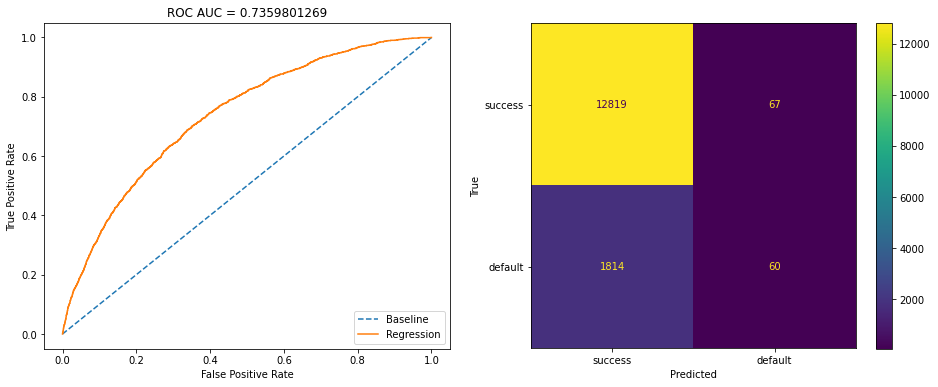

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732418,0.872493,0.462963,0.026681,0.050454
0,lr+gen,0.735975,0.872425,0.465116,0.032017,0.059910
0,lr+cv+f1,0.735980,0.872561,0.472441,0.032017,0.059970


In [1759]:
from sklearn.model_selection import StratifiedKFold
# Model with generated features and LogisticRegressionCV
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
Cs = np.logspace(-5, 5, 11)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
model = LogisticRegressionCV(Cs=Cs, max_iter=1000, cv=cv, random_state=42,
                             n_jobs=-1, verbose=2, scoring='f1')
model = scorer.train(model)
print('Best C =', model.C_)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+cv+f1', y_test, y_pred, y_prob)

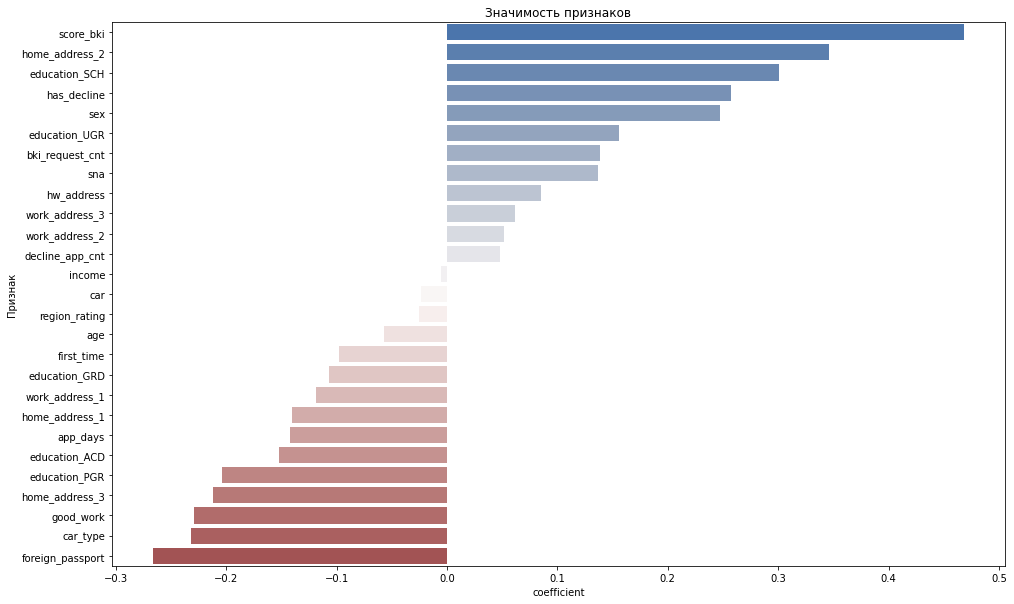

In [1760]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

In [ ]:
# Model with generated features and LogisticRegressionCV с балансировкой
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
cv = StratifiedKFold(5, shuffle=True, random_state=42)
model = LogisticRegressionCV(Cs=9, max_iter=1000, cv=cv, random_state=42,
                             penalty='l2', solver='newton-cg',
                             verbose=2, n_jobs=-1, scoring='roc_auc', class_weight='balanced')
scorer.train(model)
print('Best C =', model.C_)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+gen+cv+roc_auc+balance', y_test, y_pred, y_prob)

,sex,car,car_type,foreign_passport,good_work,has_decline,education_ACD,education_GRD,education_PGR,education_SCH,...,age,score_bki,decline_app_cnt,bki_request_cnt,income,app_days,region_rating,first_time,sna,hw_address
34802,1,0,0,0,0,0,0,0,0,0,...,-1.066854,-0.969352,-0.34032,0.001496,-1.055892,-0.309071,50,1,1,3
39763,0,1,0,0,0,0,0,1,0,0,...,0.148478,0.098846,-0.34032,-0.442317,0.216378,1.186019,40,3,1,5
22289,0,0,0,1,0,0,0,0,0,0,...,-1.500901,-0.588040,-0.34032,-0.442317,-2.602713,0.282736,50,1,1,5
19037,1,1,1,0,0,0,0,0,0,0,...,-0.545997,0.962063,-0.34032,-0.886130,1.244753,-1.679569,70,3,1,4
15228,0,0,0,0,0,0,0,0,0,1,...,-1.414091,1.057010,-0.34032,0.001496,-1.055892,-0.433661,60,1,4,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

In [ ]:
# Model with generated features and LogisticRegressionCV с балансировкой
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))

grid_values = {
    'penalty': ['l2'], 
    'C': [0.01],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'class_weight': [None, 'balanced'],
}
model = LogisticRegression(max_iter=1000, random_state=42)
model_cv = GridSearchCV(model, grid_values, cv=5, n_jobs=-1, verbose=3, 
                        scoring=['f1', 'roc_auc'], refit='roc_auc')
model_cv.fit(scorer.prepare_fit_transform()[0], scorer.get_target())
print('Best params', model_cv.best_params_)
model = model_cv.best_estimator_

scorer.train(model)

y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+gen+gs+roc_auc+f1', y_test, y_pred, y_prob)

In [ ]:
#showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

In [ ]:
class ScorerSampler(ScorerGen):
    def __init__(self, X_train, y_train):
        super().__init__(X_train, y_train)
        self._sampler = None
    
    def prepare_fit_transform(self):
        assert(self._sampler is not None)
        (df, features)  = self.prepare(self._data, self._features)
        df = self.fit(df, features).transform(df, features)
        X_resampled, y_resampled = self._sampler.fit_resample(df, self._target)
        print(X_resampled.shape)
        return X_resampled, y_resampled

    def train(self, model):
        assert(self._sampler is not None)
        self._model = model
        assert(self._model is not None)
        (df, features) = self.prepare(self._data, self._features)
        df = self.fit(df, features).transform(df, features)
        X_resampled, y_resampled = self._sampler.fit_resample(df, self._target)
        print(X_resampled.shape)
        self._model.fit(X_resampled, y_resampled)
        return model

In [ ]:
from imblearn import over_sampling, under_sampling
class ScorerOver(ScorerSampler):
    '''
    Класс для сэмплирования незбалансированных данных
    '''
    def __init__(self, X_train, y_train):
        super().__init__(X_train, y_train)
        self._sampler = over_sampling.RandomOverSampler(random_state=42)
#        self._sampler = over_sampling.SMOTE()
#        self._sampler = over_sampling.ADASYN()
        


In [ ]:
# Model with generated features and LogisticRegressionCV and sampling
from sklearn.model_selection import StratifiedKFold
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)
#'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'
scorer = ScorerOver(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
model = LogisticRegression(C=0.01, max_iter=1000, random_state=42, solver='saga')
model = scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+cv+roc_auc+oversamp', y_test, y_pred, y_prob)


In [ ]:
from imblearn import over_sampling, under_sampling
class ScorerUnder(ScorerSampler):
    '''
    Класс для сэмплирования незбалансированных данных
    '''
    def __init__(self, X_train, y_train):
        super().__init__(X_train, y_train)
        self._sampler = under_sampling.RandomUnderSampler(random_state=42)
#        self._sampler = over_sampling.NearMiss(version=1)()



In [ ]:
# Model with generated features and LogisticRegressionCV and sampling
from sklearn.model_selection import StratifiedKFold
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerUnder(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
model = LogisticRegression(C=0.01, max_iter=1000, random_state=42, solver='saga')
model = scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+cv+roc_auc+undersamp', y_test, y_pred, y_prob)

In [ ]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

In [ ]:
# Построение XGB модели c балансировкой
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))

sum_pos = sum(y_train)
sum_neg = len(y_train) - sum_pos
class_weights=[1, sum_neg / sum_pos]
model = XGBClassifier(random_state=42, subsample=0.8, reg_lambda=50, n_estimators=50, 
                      max_depth=3, learning_rate=0.2, colsample_bytree=0.5,
                      scale_pos_weight=sum_neg / sum_pos,
                      objective='binary:logistic', 
                      n_jobs=-1, use_label_encoder=False)
scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('xgb', y_test, y_pred, y_prob)

In [ ]:
class ScorerBoost(ScorerBase):
    '''
    Для CatBoost избавимся от onehot кодирования, где-то прочитал что сие не есть хорошо
    '''
    
    def boxcox(self, df):
        boxcox_df = df.copy()
        for f in df.columns:
            zero_indices = df[f] == 0
            bc, lam = stats.boxcox(df.loc[df[f] > 0, f])
            boxcox_df.loc[~zero_indices, f] = bc
            boxcox_df.loc[zero_indices, f] = -1 / lam
        return boxcox_df    
    
    def prepare(self, df, features):
        (df, features) = super().prepare(df, features)
        # Add features
        df['income'] = self.boxcox(df[['income']])
#        df['bki_request_cnt'] = self.boxcox(df[['bki_request_cnt']])
        df['car_type2'] = df['car'] + df['car_type']
#        df['car_type2'] = df['car_type2'].map({'NY': 0, 'NN': 1, 'YN': 2, 'YY': 3})
        features['cat'].append('car_type2')
        df['app_days'] = (df['app_date'] - datetime(2014, 1, 1)).dt.days
        features['num'].append('app_days')
        df['hw_address'] = df['home_address'] + df['work_address']
        features['ord'].append('hw_address')
        edu_map = {'UNK': 0, 'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}
        df['education'] = df['education'].map(edu_map)
        features['ord'].append('education')
        features['cat'].remove('education')
                        
        # remove features
        df = df.drop('car', axis=1)
        features['bin'].remove('car')
        df = df.drop('car_type', axis=1)
        features['bin'].remove('car_type')
        df = df.drop('home_address', axis=1)
        features['cat'].remove('home_address')
        df = df.drop('work_address', axis=1)
        features['cat'].remove('work_address')
 
        return df, features
    
            

In [ ]:
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))

sum_pos = sum(y_train)
sum_neg = len(y_train) - sum_pos
class_weights=[1, sum_neg / sum_pos]
model = CatBoostClassifier(iterations=300,
                           metric_period=100,
                           random_seed=42,
                           depth=3,
                           l2_leaf_reg=8,
                           eval_metric='AUC',
                           early_stopping_rounds=10,
                           learning_rate=0.05,
                           class_weights=class_weights
                          )

scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('catboost', y_test, y_pred, y_prob)


In [ ]:
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
X_train, X_test, y_train, y_test = split(data)

# Построение RandomForest модели c балансировкой
scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))

model = RandomForestClassifier(n_estimators=100, max_depth=5,
                               class_weight='balanced', random_state=42)

scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('rf+balanced', y_test, y_pred, y_prob)


In [ ]:
############################################
# Выбор модели
ScorerHistory.scores_df.sort_values('roc_auc', ascending=False)

In [ ]:
# Похоже из рассмотренных классификаторов оптимален catboost+gen+roc_auc
# но выбираем: LogisticRegression так как xgd и catboost похоже переобучились
model = LogisticRegression(C=0.01, max_iter=1000, penalty='l2', solver='saga', class_weight='balanced')
sum_pos = sum(y_train)
sum_neg = len(y_train) - sum_pos
class_weights=[1, sum_neg / sum_pos]
model = CatBoostClassifier(iterations=300,
                           metric_period=100,
                           depth=3,
                           l2_leaf_reg=6,
                           eval_metric='AUC',
                           early_stopping_rounds=10,
                           learning_rate=0.05,
                           class_weights=class_weights
                          )


In [ ]:
train = pd.read_csv('../input/sf-dst-scoring/train.csv')
test = pd.read_csv('../input/sf-dst-scoring/test.csv')
X_train = train.drop('default', axis=1)
y_train = train['default']
X_test = test

sum_pos = sum(y_train)
sum_neg = len(y_train) - sum_pos
class_weights=[1, sum_neg / sum_pos]
model = CatBoostClassifier(iterations=300,
                           metric_period=100,
                           random_seed=42,
                           depth=3,
                           l2_leaf_reg=8,
                           eval_metric='AUC',
                           early_stopping_rounds=10,
                           learning_rate=0.05,
                           class_weights=class_weights
                          )

scorer = ScorerGen(X_train, y_train)
model = scorer.train(model)
y_prob = scorer.predict_proba(X_test)
sample_submission = X_test[['client_id']].copy()
sample_submission['default'] = y_prob
sample_submission.head()

In [ ]:
sample_submission.to_csv('submission_cb.csv', index=False)
sample_submission.head(10)

## Выводы:
Рассмотренные модели дают примерно одинаковый ROC-AUC (0.73+-).
Модели с балансировкой классов дают в разы больший F1.
Наверное, настройкой гиперпараметров XGD и CatBoost можно добиться улучшения результата, но зато с
логистической регрессией работать проще (меньше гиперпараметров).
Можно сгенерировать еще признаки (например полиномиальные), но тогда значитльно упадет интерпретируемость модели.